# RRAM Relaxation Data Notebook

This notebook contains the analysis on empirical RRAM relaxation data across three technologies (A, B, C). It loads and processes the measurements taken for each technology.

In [132]:
# Imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
# from matplotlib.offsetbox import AnchoredText

## Load the data and settings

Below, choose which technology to load data and settings for:

In [4]:
# Choose technology here
TECH = "C"
FULLDATA = False

# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

# Load data for technology
colnames = ["addr", "time", "r", "g"]
if FULLDATA: # Load full dataset
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
    tsdata = pd.read_csv(f"data/tech{TECH}/tsdata.tsv.gz", names=colnames, sep='\t')
else: # Load small dataset (only includes data that is actually used)
    data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
    tsdata = pd.read_csv(f"data/tech{TECH}/tsdata.min.tsv.gz", names=colnames, sep='\t')

## Time series analysis
In this section, we will look at example time series data on a log scale and also examine the power spectral density (PSD). First, choose the ranges to analyze:

In [440]:
# Get ranges to plot time series and PSD for
ranges = np.array([0, 8, 16, 31])

# Get addrs to plot time series PSD for
if FULLDATA:
    # Use PSD index offsets to select the correct cells
    indices = ranges + np.array(settings["tsIndexOffsets"]) * 32

    # Output data to small file
    fopts = {"sep": '\t', "header": False, "index": False}
    #tsdata[tsdata["addr"].isin(addrs)].to_csv(f"data/tech{TECH}/tsdata.min.tsv.gz", **fopts)
else:
    # Use indices sequentially if using minimal data set
    indices = range(len(ranges))
addrs = tsdata[tsdata["time"] == 0]["addr"].to_numpy()[indices]

### Example Time Series Data

Below, we can look at the time series data for the ranges chosen above:

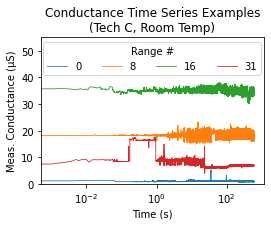

In [456]:
# Plot long-term power spectral density (PSD)
fig = plt.figure(figsize=(4,2.7))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Time Series Examples\n(Tech {TECH}, Room Temp)")
for r, addr in zip(ranges, addrs):
    # Select data
    d = tsdata[(tsdata["addr"] == addr) & (tsdata["time"] >= 0) & (tsdata["time"] < 1e10)]

    # Plot time series data
    plt.plot(d["time"], d["g"]*1e6, label=r, linewidth=0.8)

# Format and display
ax.legend(title="Range #", ncol=4, loc=9)
ax.set_ylim(*settings["tsylim"])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Meas. Conductance (µS)")
ax.set_xscale("log")
plt.show()

### Power Spectral Density (PSD)

In this section, we will look at the PSDs to understand the relaxation behavior better:

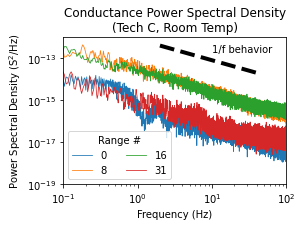

In [447]:
# Plot power spectral density (PSD)
fig = plt.figure(figsize=(4,2.7))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Power Spectral Density\n(Tech {TECH}, Room Temp)")
slopes = []
for r, addr in zip(ranges, addrs):
    # Select data
    d = tsdata[(tsdata["addr"] == addr) & (tsdata["time"] >= 0) & (tsdata["time"] < 1e10)]

    # # Lomb-Scargle PSD
    # f = np.logspace(np.log10(1/600), np.log10(2), 500)
    # f = np.logspace(np.log10(2), np.log10(400/2), 1000)
    # p = scipy.signal.lombscargle(d["time"], d["g"], f)

    # Welch PSD
    f, p = scipy.signal.welch(d["g"], fs=settings["fs"], nperseg=settings["psdnperseg"])
    plt.plot(f, p, label=r, linewidth=0.8)

    # # Power law fit
    # a, b = np.polyfit(np.log(f[[30,-30]]), np.log(p[[30,-30]]), 1)
    # print(f"Range {r} slope: {a}")
    # slopes.append(a)
    # plt.plot(f[1:], np.exp(a*np.log(f[1:]) + b), 'k--', zorder=10, linewidth=2)

    # # 1/f fit
    # fitfn = lambda logf, A: A - logf
    # params, _ = scipy.optimize.curve_fit(fitfn, np.log(f), np.log(p))
    # A = params[0]
    # print(A)
    # plt.plot(f, np.exp(fitfn(np.log(f), A)), 'k--', zorder=10, linewidth=2)

# Format and display
# ax.add_artist(AnchoredText("Slopes: [%.2f, %.2f]" % (max(slopes), min(slopes)), loc=1, frameon=False))
plt.plot(*settings["psdFpts"], 'k--', zorder=10, linewidth=4)
ax.legend(title="Range #", ncol=2)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power Spectral Density (S$^2$/Hz)")
ax.set_xscale("log")
ax.set_xlim(*settings["psdxlim"])
ax.set_ylim(*settings["psdylim"])
ax.set_yscale("log")
plt.text(*settings["psdFtextloc"], "1/f behavior")
plt.show()

In [455]:
settings={
    "gmax": 40e-6,
    "fs": 400,
    
    "tsIndexOffsets": [0, 2, 4, 0],

    "tsylim": [0, 55],

    "psdnperseg": 65536,
    "psdxlim": [1e-1, 1e2],
    "psdylim": [1e-19, 1e-12],
    "psdFpts": [[2e0, 4e1], [4e-13, 2e-14]],
    "psdFtextloc": [1e1, 2e-13]
}